In [12]:
from mantaray.core import single_ray, ray_tracing
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Step Function Bathymetry

### Create Bathymetry and Null Current Files

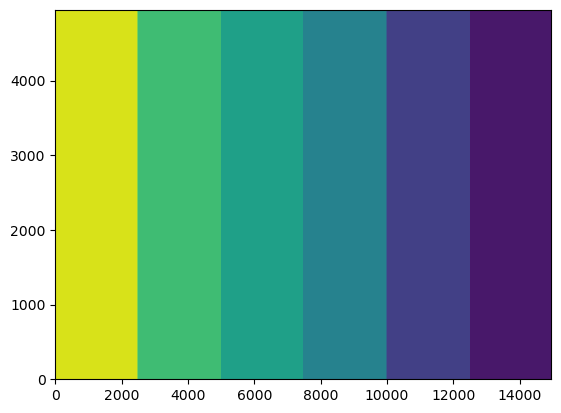

In [13]:
# Create Baythymetry
NX = 300
NY = 100
dl = 50
xs = np.arange(0, NX)*dl
ys = np.arange(0, NY)*dl
xss, yss = np.meshgrid(xs, ys)
coords = xss*yss
depth_max = 140
d_depth = 20
n_shelfs = 6
depth = depth_max - np.floor(np.linspace(0, n_shelfs, NX, endpoint=False))*d_depth
bathymetry = depth*np.ones((len(ys),len(xs)))
fig, ax = plt.subplots()
ax.contourf(xss, yss, bathymetry)

In [14]:
# Create and save bathymetry as Dataset
bathymetry_array = xr.Dataset(data_vars={'depth':(('y','x'), bathymetry)}, coords={'x':('x',np.float64(xs)), 'y':('y',np.float64(ys))})
bathymetry_array.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/bathymetry.nc', format='NETCDF3_CLASSIC')

In [15]:
# Create and save null currents
null_current = xr.Dataset(data_vars={'u':(('x','y'), np.zeros_like(coords).T),'v':(('x','y'), np.zeros_like(coords).T)}, coords={'y':ys, 'x':xs})
null_current.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_current.nc', format='NETCDF3_CLASSIC')

### Define Ray and Run Ray Trace

In [16]:
# Define wave number
k = 2*np.pi/20000 # lambda = 100m
phi0 = 20*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)
omega = np.sqrt(depth_max*9.81)*k

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [17]:
# Run Single Ray Trace with bathymetry and null current developed above
ray_evolution_raw = single_ray(x0, y0, kx, ky, 1000, 0.5,
                           bathymetry='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/bathymetry.nc',
                           current='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_current.nc')

In [18]:
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
                                         phi = np.arctan(ray_evolution_raw.ky/ray_evolution_raw.kx))

### Analytically Solve for Ray Path

In [19]:
# Create simplified depths, wave speeds wave number magnitudes with one value per bathymetry "shelf"
depth_levels = depth_max - np.arange(0, n_shelfs)*d_depth
cs = np.sqrt(9.81*depth_levels)
ks = omega/cs

# Iterate over each shelf to compute the analytically expected angle
phis = np.ones_like(depth_levels, dtype=float)
for i in range(len(phis)):
    if i == 0:
        phis[i] = phi0
    else:
        phis[i] = phis[i-1]*cs[i]/cs[i-1]

In [20]:
# Create arrays identifying the start, midpoint, and end of each shelf
shelf_starts = np.linspace(0, NX*dl, n_shelfs, endpoint=False)
mid_shelf_xs = shelf_starts + (NX*dl) / (2*n_shelfs)

# Create analytical ray x coordinates (one point on each shelf boundary)
xs_analytical = np.linspace(0, NX*dl, n_shelfs+1)

# Compute analytical ray y coordinates (Using y=m(x-x0) + y0 to propagate between shelves)
y0a = y0 + 50
ys_analytical = np.ones(7)
ys_analytical[0] = y0a
for i, phi in enumerate(phis):
    ys_analytical[i+1] = np.tan(phi) * NX*dl / n_shelfs + ys_analytical[i]

In [21]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(data=ray_evolution.phi.values[:-1], coords={'x':ray_evolution.x.values[:-1]})

# Find the difference and percent difference between the analytical and computational ray traces
phi_diffs = np.abs(phis - ray_angles.sel(x=mid_shelf_xs, method='nearest'))
phi_diffs_percent = phi_diffs / phis * 100

In [56]:
np.array([20], dtype=int)

array([20])

In [55]:
np.concatenate

array([140, 120, 100,  80,  60,  40])

In [59]:
np.concat((depth_levels, np.array([20], dtype=int)))

array([140, 120, 100,  80,  60,  40,  20])

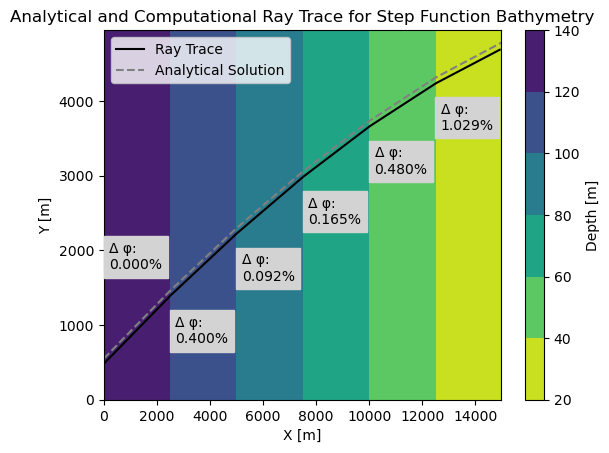

In [60]:
# Plot the Ray Comparisons
fig, ax = plt.subplots()
contours = ax.contourf(bathymetry_array.x, bathymetry_array.y, bathymetry_array.depth, cmap='viridis_r', levels=np.flip(np.concatenate((depth_levels, np.array([20,])))))
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black', label='Ray Trace')
ax.plot(xs_analytical, ys_analytical, marker='', linestyle='dashed', color='grey', label='Analytical Solution')
for i, pcent_diff in enumerate(phi_diffs_percent):
    if i == 0:
        ax.text(x=shelf_starts[i] + 200, y=ys_analytical[i]+1200, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
        continue
    ax.text(x=shelf_starts[i] + 200, y=ys_analytical[i]-700, s='Δ φ: \n' + "{0:1.3f}".format(pcent_diff) + '%', backgroundcolor='lightgrey')
ax.legend()
ax.set_title(label='Analytical and Computational Ray Trace for Step Function Bathymetry')
ax.set_xlabel(xlabel='X [m]')
ax.set_ylabel(ylabel='Y [m]')
cax = fig.colorbar(contours, label='Depth [m]')

Snell's Law (For Bathymetry Only):

$\frac{sin(\phi_1)}{sin(\phi_2)} = \frac{c_1}{c_2} = \frac{|\vec{K_2}|}{|\vec{K_1}|}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ and $c_2$ are the phase speeds of the wave before and after crossing the interface, and $\vec{K_1}$ and $\vec{K_2}$ are the wavenumbers of the incident and transmitted waves, respectively.

In the shallow water approximation, $c = \sqrt{g d}$, where g is the acceleration of gravity and d is the depth of the wave.

## Shear Current

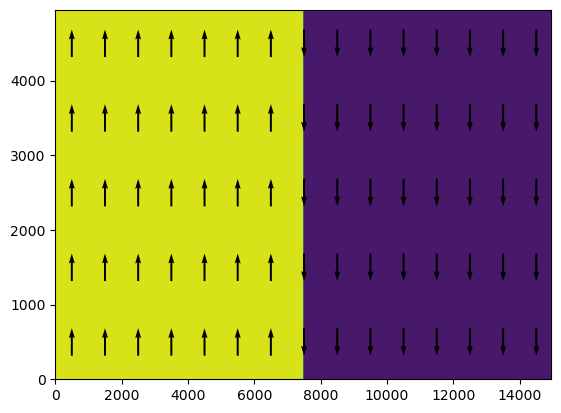

In [13]:
# Create Currents
NX = 300
NY = 100
dl = 50
xs = np.arange(0, NX)*dl
ys = np.arange(0, NY)*dl
xxs, yys = np.meshgrid(xs, ys)
coords = xxs*yys
u1 = 1
u2 = -1
current_xs = 1 - np.floor(np.linspace(0, 2, NX, endpoint=False))*2
currents = current_xs*np.ones((len(ys),len(xs)))
fig, ax = plt.subplots()
ax.contourf(xxs, yys, currents)
ax.quiver(xxs[10::20,10::20], yys[10::20,10::20], np.zeros_like(currents)[10::20,10::20], currents[10::20,10::20], color='black',
          pivot='middle', width=0.004)

In [14]:
# Create and save bathymetry as Dataset
bathymetry_array = xr.Dataset(data_vars={'depth':(('y','x'), np.ones_like(coords)*2000)}, coords={'x':('x',np.float64(xs)), 'y':('y',np.float64(ys))})
bathymetry_array.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_bathymetry.nc', format='NETCDF3_CLASSIC')

In [15]:
# Create and save null currents
null_current = xr.Dataset(data_vars={'u':(('y','x'), currents),'v':(('y','x'), np.zeros_like(currents))}, coords={'y':ys, 'x':xs})
null_current.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/current.nc', format='NETCDF3_CLASSIC')

In [16]:
# Define wave number
k = 2*np.pi/15 # lambda = 50m
phi0 = 20*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [17]:
ray_evolution = single_ray(x0, y0, kx, ky, 40000, 10,
                           bathymetry='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_bathymetry.nc',
                           current='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/current.nc')
ray_evolution

<xarray.Dataset> Size: 145kB
Dimensions:  (time_step: 3622)
Coordinates:
    time     (time_step) float64 29kB 0.0 10.0 20.0 ... 3.62e+04 3.621e+04
    x        (time_step) float64 29kB 50.0 82.73 115.5 ... 1.034e+04 nan
    y        (time_step) float64 29kB 500.0 508.3 516.5 ... 4.924e+03 nan
Dimensions without coordinates: time_step
Data variables:
    kx       (time_step) float64 29kB 0.3936 0.3936 0.3936 ... 2.073 2.073 nan
    ky       (time_step) float64 29kB 0.1433 0.1433 0.1433 ... 0.1433 0.1433 nan
Attributes:
    date_created:  2025-02-02 15:40:17.063877

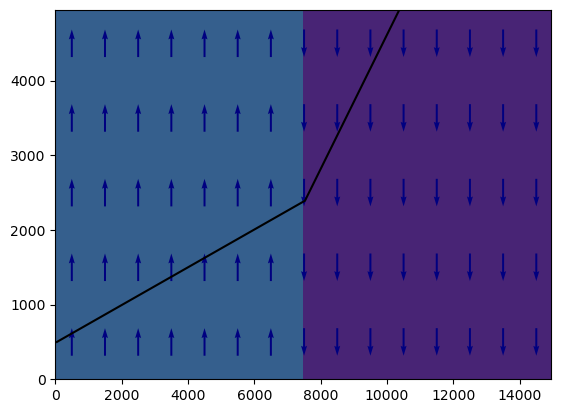

In [18]:
fig, ax = plt.subplots()
ax.contourf(xxs, yys, currents, cmap='viridis', levels=np.arange(-1, 5))
ax.quiver(xxs[10::20,10::20], yys[10::20,10::20], np.zeros_like(currents)[10::20,10::20], currents[10::20,10::20], color='navy',
          pivot='middle', width=0.004)
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black')